# Read Data

In [64]:
import pandas as pd
import numpy as np
import functools as ft
import os
from typing import List, Set, Dict, Tuple
from utils import get_conn, query_aws, PROJ_DIR
from icd9.icd9 import ICD9, Node
from ast import literal_eval
import sklearn
import tqdm
from itertools import chain
from collections import Counter
import math

In [7]:
# read in list of all notes
notes = query_aws("select text from mimiciii.noteevents limit 100")
notes = notes["text"].tolist()

In [103]:
# read in raw data
df = pd.read_pickle("data/preprocessed/sub.pd")

In [104]:
df.head()

,roots,text,hadm_id,tokens,d2v,w2v_idx,bert_idx
309743,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]",clinical nutrition:\no:\n~38 week cga bb on do...,161889.0,"[clinical, nutrition, week, bb, dol, wt, -5, %...","[-0.1278176, 0.058999088, -0.022888184, 0.0931...","[3504, 7518, 116, 122638, 620641, 156240, 5004...","[[tensor(101), tensor(7300), tensor(20121), te..."
43668,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]",resp care\npt remains intubated. current vent ...,108868.0,"[resp, care, pt, remains, intubated, current, ...","[-0.024176462, 0.054421652, -0.017717633, 0.05...","[375558, 643, 69372, 986, 224584, 403, 20428, ...","[[tensor(101), tensor(1231), tensor(20080), te..."
341533,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]",3. fen-todays wt is 2275 (up 20 grams). tf=150...,168216.0,"[3., wt, grams, po, bottled, far, shift, tired...","[-0.017221848, 0.053173713, -0.019555254, 0.06...","[1087362, 156240, 9612, 112370, 24771, 353, 27...","[[tensor(101), tensor(124), tensor(119), tenso..."
105203,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",rehab/ot\n\not consult received and appreciate...,121278.0,"[ot, consult, received, appreciated, infant, a...","[-0.015978755, 0.026359247, -0.0026973803, 0.0...","[69614, 9449, 510, 6256, 8553, 12307, 2267, 15...","[[tensor(101), tensor(1231), tensor(17266), te..."
74903,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",3:26 pm\n ct abdomen w/contrast; ct pelvis w/...,115078.0,"[pm, ct, abdomen, ct, pelvis, clip, #, ct, non...","[-0.027752148, 0.11007369, -0.026815249, 0.006...","[275, 130502, 17830, 130502, 38465, 7967, 2992...","[[tensor(101), tensor(124), tensor(131), tenso..."


# Exploratory Visualizations

In [7]:
from scripts.visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns

## Summary Table

In [126]:
summary_table = pd.read_csv("data/full_summary.csv")

In [127]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [435]:
summary_table.astype("int")

,Totals,Male,Medicare,Female,Private,Medicaid,Government,Self Pay
Category,,,,,,,,
Patients,46520,26121,21002,20399,19663,4570,1614,600
Admissions,58976,32950,28215,26026,22582,5785,1783,611
ICD9 Codes,11501,5852,5023,5649,5718,3989,2657,1467
Deaths,5836,3141,3903,2695,1372,381,90,95
Admissions Per Patient,1,1,1,1,1,1,1,1
ICD9 Codes Per Patient,0,0,0,0,0,0,1,2
ICD9 Codes Per Admission,0,0,0,0,0,0,1,2
Death Per Patient,0,0,0,0,0,0,0,0


In [432]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [433]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [434]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED ...,18358,228


## Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

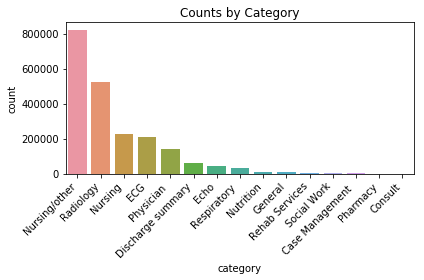

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distribution of ICD Codes in Note

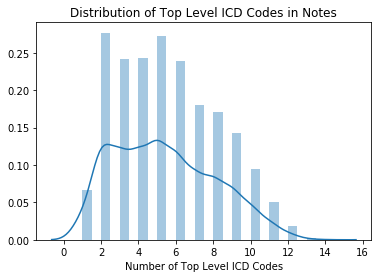

In [47]:
lens = [len(r) for r in model_df["roots"].tolist()]
ax = sns.distplot(lens)
ax.set(xlabel="Number of Top Level ICD Codes",
       title="Distribution of Top Level ICD Codes in Notes")
plt.savefig("images/num_icd_codes.png")
plt.show()

## Distribution of Word Counts in Notes

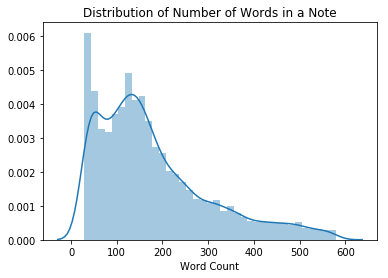

In [376]:
with get_conn() as conn:
    cursor = conn.cursor()
    notes = as_pandas(cursor.execute("select text from mimiciii.noteevents order by RAND() limit 10000;"))["text"]
lens = notes.apply(lambda x: len(x.split()))
no_outliers = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]
ax = sns.distplot(no_outliers)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig("images/word_counts.png")
plt.show()

## ICD Codes by Insurance

In [413]:
# read data
with get_conn() as conn:
    cursor = conn.cursor()
    query = """
    select admissions.hadm_id as adm_id, count(diagnoses_icd.icd9_code) as icd, array_agg(admissions.insurance)[1] as insurance
    from mimiciii.admissions as admissions
    join mimiciii.diagnoses_icd as diagnoses_icd
    on admissions.hadm_id = diagnoses_icd.hadm_id
    group by admissions.hadm_id;
    """
    insur_icd_df = as_pandas(cursor.execute(query))

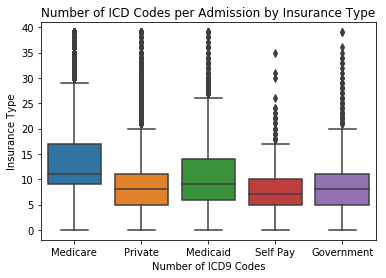

In [603]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig("images/insurance.png")
plt.show()

## Word Cloud

In [111]:
from wordcloud import WordCloud

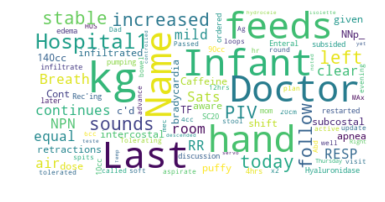

In [117]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(notes[15])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("images/wordcloud.png")
plt.show()

# Embedding

## Word2vec

In [110]:
from gensim.models import KeyedVectors

In [113]:
w2v_fp = "data/embeddings/GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

## BERT

In [43]:
from transformers import AutoTokenizer, AutoModel
import spacy
import torch
nlp = spacy.load("en_core_web_sm")

In [45]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [48]:
t = torch.tensor(tokenizer.encode(notes[0], add_special_tokens=True)).unsqueeze(0)

In [15]:
def tokenize_doc(text: str, tokenizer, nlp):
    """Mark doc with sent tokens for bert."""
    doc = nlp(text)
    sents = [sent.string.strip() for sent in doc.sents]
    marks = " ".join(["[CLS]" + sent + "[SEP]" for sent in sents])
    toks = tokenizer.tokenize(marks)
    return toks

In [39]:
def get_segments(tokens):
    segments = [0]
    cur_seg = 0
    for tok in tokens[1:]:
        if tok == "[CLS]":
            cur_seg = 0 if cur_seg == 1 else 1
        segments.append(cur_seg)
    return segments

In [46]:
with torch.no_grad():
    encoded_layers, _ = model(torch.tensor(ids), torch.tensor(segs))

ValueError: Wrong shape for input_ids (shape torch.Size([83])) or attention_mask (shape torch.Size([83]))

In [40]:
toks = tokenize_doc(notes[0], tokenizer, nlp)
ids = tokenizer.convert_tokens_to_ids(toks)
segs = get_segments(toks)

In [41]:
pd.DataFrame({"tokens": toks, "ids": ids, "segs": segs})

,tokens,ids,segs
0,[CLS],101,0
1,nursing,11138,0
2,ni,11437,0
3,##cu,10182,0
4,note,3805,0
5,add,5194,0
6,##end,6696,0
7,##um,1818,0
8,.,119,0
9,[SEP],102,0


In [18]:
model(toks)

AttributeError: 'list' object has no attribute 'size'

In [25]:
tokens = tokenizer.tokenize(notes[0])
ids = tokenizer.convert_tokens_to_ids(tokens)
pd.DataFrame({"tokens": tokens, "ids": ids})

,tokens,ids
0,nursing,11138
1,ni,11437
2,##cu,10182
3,note,3805
4,add,5194
5,##end,6696
6,##um,1818
7,.,119
8,mother,1534
9,in,1107


# Model

In [105]:
import torch
import torch.nn as nn
from utils import Batcher, ICDDataset

In [106]:
class Lstm(nn.Module):
    """An LSTM implementation with sklearn-like methods."""

    def __init__(self, weights):
        super(Lstm, self).__init__()
        # instance variables
        self.weights: torch.tensor = weights
        self.n_code: int = 15
        self.embedding_dim: int = 300
        self.lstm_size: int = 128
        self.batch_size: int = 64
        self.n_epochs: int = 30
        self.embeddings = nn.Embedding.from_pretrained(self.weights)
        self.lstm = nn.LSTM(self.embedding_dim, self.lstm_size)
        self.hidden2code = nn.Linear(self.lstm_size, self.n_code)

    def forward(self, X: List[List[int]]) -> torch.tensor:
        # zero pad sequences such that all are length of longest seq
        seq_lens = torch.Tensor([len(seq) for seq in X])
        X = [torch.LongTensor(samp) for samp in X]
        pad_X = pad_sequence(X)

        # get embeddings
        embeds = self.embeddings(pad_X)

        # pack padded sequences
        pack_X = pack_padded_sequence(embeds, seq_lens, enforce_sorted=False)

        # propagate through network
        _, (h_n, _) = self.lstm(pack_X)
        code_space = self.hidden2code(h_n)
        code_scores = torch.sigmoid(code_space).squeeze()
        return code_scores

    def fit(self, X: List[List[int]], Y: List[List[int]]):
        """Train network on training set."""
        # initialize batcher
        dataset = ICDDataset(X, Y)
        batcher = Batcher(dataset, batch_size=self.batch_size)

        # initialize parameters
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

        # propagate through network
        print("Training LSTM .....")
        for i in range(self.n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for X_batch, Y_batch in batcher:

                # zero the parameter gradients
                self.zero_grad()

                # retrieve outputs
                outputs = self.forward(X_batch)

                # determine loss and backprop
                loss = loss_fn(outputs, Y_batch)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters

            print(f"loss = {loss}")
        print("done.")
        return self

In [109]:
dataset = ICDDataset(df["w2v_idx"].tolist(), df["roots"].tolist())
batcher = Batcher(dataset)

In [ ]:
lstm = Lstm(word2vec.vectors)
lstm.run_train(batcher)

# Results

## Load Classifiers

In [42]:
from sklearn.neural_network import MLPClassifier

In [6]:
import pickle

## Performance Results

In [394]:
# get performance data
f1s = [f1_score(vals["Y_test"], vals["preds"], average="weighted", zero_division=1) for vals in clfs.values()]
accs = [ml_accuracy(vals["Y_test"], vals["preds"]) for vals in clfs.values()]
precs = [precision_score(vals["Y_test"], vals["preds"], average="weighted", zero_division=1) for vals in clfs.values()]
recs = [recall_score(vals["Y_test"], vals["preds"], average="weighted", zero_division=1) for vals in clfs.values()]
metrics = f1s + accs + precs + recs
met_labels = ["F1 Score"] * len(pred_clfs) + ["Accuracy"] * len(pred_clfs)\
             + ["Precision"] * len(pred_clfs) + ["Recall"] * len(pred_clfs)
clf_names = list(pred_clfs.keys()) * 4

ValueError: Found input variables with inconsistent numbers of samples: [1702, 3971]

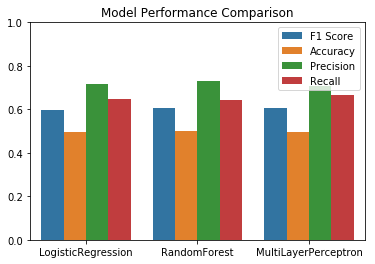

In [30]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
ax.set(title="Model Performance Comparison")
plt.savefig("data/images/model_comparison.png")
plt.show()

## Classification Reports

In [186]:
class_reports = {name: classification_report(Y_test, Y_pred, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for name, Y_pred in pred_clfs.items()}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [418]:
probs = lstm(nn_X_test)
pos = torch.where(probs < 0.5, probs, torch.ones(*probs.shape))
neg = torch.where(pos > 0.5, pos, torch.zeros(*probs.shape))
torch_preds = neg.long().numpy()

In [420]:
ml_accuracy(nn_Y_test, torch_preds)

0.4390111830329211

In [419]:
rep = classification_report(nn_Y_test, torch_preds, target_names=class_names,
                      zero_division=1)
print(rep)

              precision    recall  f1-score   support

     001-139       1.00      0.00      0.00       717
     140-239       1.00      0.00      0.00       234
     240-279       0.57      1.00      0.73       977
     290-319       1.00      0.00      0.00       362
     320-389       1.00      0.00      0.00       498
     390-459       0.80      1.00      0.89      1355
     460-519       0.62      1.00      0.76      1053
     520-579       0.56      0.01      0.01       820
     580-629       0.55      1.00      0.71       930
     680-709       1.00      0.00      0.00       256
     710-739       1.00      0.00      0.00       202
     760-779       1.00      0.00      0.00       117
     780-799       1.00      0.00      0.00       728
     800-999       0.52      1.00      0.69       886
     V01-V91       0.58      1.00      0.73       986

   micro avg       0.61      0.61      0.61     10121
   macro avg       0.81      0.40      0.30     10121
weighted avg       0.73   

In [189]:
crep_df

LogisticRegression                               \
                       f1-score precision    recall  support   
001-139                0.579779  0.672161  0.509722    720.0   
140-239                0.031496  1.000000  0.016000    250.0   
240-279                0.741564  0.617970  0.926955    972.0   
290-319                0.000000  1.000000  0.000000    405.0   
320-389                0.044037  0.545455  0.022945    523.0   
390-459                0.897410  0.817903  0.994039   1342.0   
460-519                0.793625  0.694077  0.926512   1075.0   
520-579                0.623102  0.675250  0.578431    816.0   
580-629                0.762610  0.684385  0.861024    957.0   
680-709                0.000000  1.000000  0.000000    284.0   
710-739                0.000000  1.000000  0.000000    198.0   
760-779                0.520548  1.000000  0.351852    108.0   
780-799                0.314607  0.628571  0.209809    734.0   
800-999                0.684129  0.619535  0.763761    872.0   
V01-V91                0.744877  0.621730  0.928858    998.0   
micro avg              0.666103  0.679833  0.652916  10254.0   
macro avg              0.449186  0.771803  0.472661  10254.0   
weighted avg           0.594107  0.710621  0.652916  10254.0   
samples avg            0.628580  0.666558  0.651551  10254.0   

             MultiLayerPerceptron                              RandomForest  \
                         f1-score precision    recall  support     f1-score   
001-139                  0.648536  0.651261  0.645833    720.0     0.570962   
140-239                  0.315113  0.803279  0.196000    250.0     0.039216   
240-279                  0.724382  0.634675  0.843621    972.0     0.744244   
290-319                  0.116331  0.619048  0.064198    405.0     0.085106   
320-389                  0.252226  0.562914  0.162524    523.0     0.135182   
390-459                  0.905367  0.860403  0.955291   1342.0     0.895673   
460-519                  0.799829  0.741653  0.867907   1075.0     0.790808   
520-579                  0.660070  0.628603  0.694853    816.0     0.623256   
580-629                  0.759881  0.720712  0.803553    957.0     0.773125   
680-709                  0.146789  0.558140  0.084507    284.0     0.067797   
710-739                  0.000000  1.000000  0.000000    198.0     0.029851   
760-779                  0.966825  0.990291  0.944444    108.0     0.597403   
780-799                  0.516425  0.587826  0.460490    734.0     0.316008   
800-999                  0.716049  0.649254  0.798165    872.0     0.678609   
V01-V91                  0.706155  0.656062  0.764529    998.0     0.743938   
micro avg                0.685491  0.696567  0.674761  10254.0     0.670434   
macro avg                0.548932  0.710941  0.552394  10254.0     0.472745   
weighted avg             0.645971  0.692625  0.674761  10254.0     0.605215   
samples avg              0.649114  0.701575  0.672081  10254.0     0.635122   

                                           
             precision    recall  support  
001-139       0.691700  0.486111    720.0  
140-239       1.000000  0.020000    250.0  
240-279       0.627382  0.914609    972.0  
290-319       1.000000  0.044444    405.0  
320-389       0.722222  0.074570    523.0  
390-459       0.814521  0.994784   1342.0  
460-519       0.688751  0.928372   1075.0  
520-579       0.680697  0.574755    816.0  
580-629       0.690789  0.877743    957.0  
680-709       0.909091  0.035211    284.0  
710-739       1.000000  0.015152    198.0  
760-779       1.000000  0.425926    108.0  
780-799       0.666667  0.207084    734.0  
800-999       0.627680  0.738532    872.0  
V01-V91       0.630662  0.906814    998.0  
micro avg     0.688052  0.653696  10254.0  
macro avg     0.783344  0.482940  10254.0  
weighted avg  0.723702  0.653696  10254.0  
samples avg   0.677549  0.653089  10254.0

## Probability Distributions

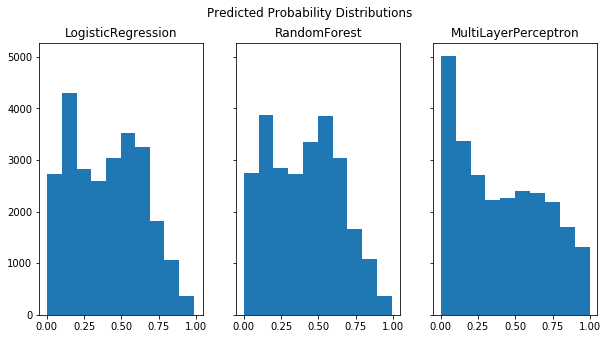

In [190]:
fig, axs = plt.subplots(1, len(prob_clfs), sharey="all", sharex="all")
for ax, name, probs in zip(axs, prob_clfs.keys(), prob_clfs.values()):
    ax.hist(probs.flatten())
    ax.set(title=name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.savefig("data/images/prob_dists.png")
plt.show()

## Precision/Recall Curves

In [191]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in thresholds:
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [192]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 100)
pr_dfs = [pr_curve(name, probs, Y_test, thresholds) for name, probs in prob_clfs.items()]
pr_df = pd.concat(pr_dfs)

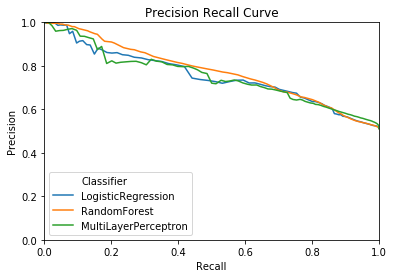

In [193]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.savefig("data/images/prec_rec.png")
plt.show()

## Category Performance

In [366]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      row_id as row_id,
      category
    FROM
      mimiciii.noteevents;
    """
    cat_df = as_pandas(cursor.execute(query))

In [377]:
cat_df.head()

,row_id,category
0,20030,Discharge summary
1,20031,Discharge summary
2,20032,Discharge summary
3,20033,Discharge summary
4,20034,Discharge summary


In [ ]:
merged_df = cat_df.merge(pd.DataFrame({"accaccs))